In [16]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from matplotlib.mlab import griddata
import matplotlib.patheffects as path_effects
from netCDF4 import Dataset
from matplotlib.colors import LightSource
import warnings
warnings.filterwarnings("ignore")
from obspy.imaging.beachball import beach
from geographiclib.geodesic import Geodesic
import math
geod = Geodesic.WGS84
from scipy.interpolate import Rbf
initfontsize=8
mpl.rc('axes', labelsize=initfontsize, titlesize=initfontsize)
mpl.rc('xtick', labelsize=initfontsize)
mpl.rc('ytick', labelsize=initfontsize)
mpl.rc('legend', fontsize=initfontsize)
mpl.rc('savefig', dpi=600)
mpl.rc('font', size=initfontsize)

In [17]:
def deptodip(ax, data, h0, dip):
    data=np.loadtxt(data)
    x, h=(data[:,2], data[:,3]*-1)
    y=(h0-h)/np.cos((90-dip)*np.pi/180)
    ax.plot(x, y, linewidth=1, alpha=0.85, color='C0')
    
def DrawTopography(m, my_example_nc_file, cmap, flag, alpha):
    fh = Dataset(my_example_nc_file, mode='r')
    lons = fh.variables['lon'][:]; lats = fh.variables['lat'][:]; tmax = fh.variables['z'][:]
    fh.close()
    lon, lat = np.meshgrid(lons, lats); xi, yi = m(lon, lat)
    ls = LightSource(azdeg=270, altdeg=45)
    cm = plt.cm.get_cmap(cmap)
    if flag == 1:
        topomax=tmax.max()
    else:
        topomax=0
    rgb = ls.shade(tmax, cmap=cm, blend_mode='overlay', vmin=tmax.min(), vmax=topomax)
    cs = m.imshow(rgb, interpolation='none', alpha=alpha, cmap=cm, vmin=tmax.min(), vmax=topomax, origin='lower')
    return cs
    
def stamap(ax, filename):
    data=np.loadtxt(filename, usecols=(4,5))
    a, d=(90-data[:,0], data[:,1])
    x, y=(d*np.cos(a*np.pi/180.0), d*np.sin(a*np.pi/180.0))
    ax.set_xlim([-110,110])
    ax.set_ylim([-110,110])
    ax.scatter(x, y, s=30, marker='^', edgecolor='none', facecolor='C3', alpha=0.85)
    ax.scatter(0, 0, s=100, marker='*', edgecolor='k', facecolor='none', alpha=0.85)
    theta=np.linspace(0, 360, 360)
    for i in [30, 90]:
        x, y=(i*np.cos(theta*np.pi/180.0), i*np.sin(theta*np.pi/180.0))
        ax.plot(x, y, color='C7', zorder=0, solid_capstyle='round', lw=0.85)
    x, y=(100*np.cos(theta*np.pi/180.0), 100*np.sin(theta*np.pi/180.0))
    ax.plot(x, y, color='k', solid_capstyle='round', lw=0.85)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('')
    plt.axis('off')
    return ax

def gensnap(ax, data, maxslip, slipint, minx, maxx, miny, maxy):
    data=np.loadtxt(data)
    strike, dip, slip=(data[:,0], data[:,1], data[:,4])
    xi=np.linspace(minx, maxx, 100)
    yi=np.linspace(miny, maxy, 100)
    X, Y=np.meshgrid(xi, yi)
    resampled=griddata(strike, dip, slip, xi, yi,'linear')
    interval=np.arange(slipint,maxslip+slipint,slipint)
    sc=ax.contour(X, Y, resampled, interval, colors='C7', linewidths=1)
    ax.scatter(0, 0, color='k', marker='+', zorder=10, linewidth=0.5, s=6)
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])
    return sc

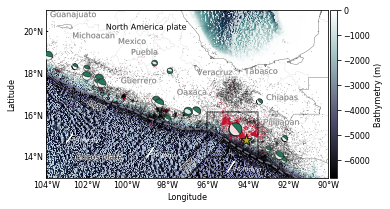

In [4]:
def drawbasemap(elon, elat, intlon, intlat):
    from matplotlib import cm
    m=Basemap(llcrnrlon=-104,llcrnrlat=13,urcrnrlon=-90,urcrnrlat=21,\
            rsphere=(6378137.00,6356752.3142),resolution='i',projection='merc')
    cs=DrawTopography(m, 'data/GEBCO_-104_-90_13_21.grd', 'bone', 0, 1)
    m.drawparallels(np.arange(-80.,81.,intlat),labels=[1,0,0,0], fontsize=initfontsize, dashes=(2,10000), color='k')
    m.drawmeridians(np.arange(-180.,181.,intlon),labels=[0,0,0,1], fontsize=initfontsize, dashes=(2,10000), color='k')
    m.drawcoastlines(color='C7', linewidth=0.5)
    m.drawcountries(color='C7', linewidth=0.5)
    m.drawstates(color='C7', linewidth=0.1)
    return m, cs

w = 5.6; h = 5.6; wh=w/h
fig=plt.figure(figsize=(w, h))
ax=fig.add_axes([0.1,0.1,0.7,0.7]) 
ax.set_xlabel('Longitude', labelpad=15)
ax.set_ylabel('Latitude', labelpad=30)
elon, elat=-93.715, 15.068
slon, slat=-94.11, 14.85
m, cs=drawbasemap(elon, elat, 2, 2)

data=np.loadtxt('data/plateb_2002Bird_Mexico.txt', delimiter=',')
x, y=m(data[:,0], data[:,1])
ax.plot(x, y, color='C7', linestyle='--')

data=np.loadtxt('data/seismicitySSNfromM4_1990_2017_Sep7th_whole.txt_shaped.txt')
x, y=m(data[:,1], data[:,0])
dep, mag=(data[:,2], data[:,3])
ax.scatter(x, y, s=0.5, alpha=0.5, edgecolor='none', facecolor='k', zorder=2)

data=np.loadtxt('data/states.txt', usecols=(2, 3))
x, y=m(data[:,1], data[:,0])
state=np.genfromtxt('data/states.txt', dtype=str, usecols=(0))
for i in np.arange(0, len(state), 1):
    text=ax.text(x[i], y[i], state[i], color='C7', size=8, ha='right')
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])

data=np.loadtxt('data/seismicitySSNfromM3aftershock7th-21th.txt_shaped.txt')
lat, lon, dep, mag=(data[:,0], data[:,1], data[:,2], data[:,3])
x, y=m(lon, lat)
ax.scatter(x, y, s=0.5, alpha=0.75, edgecolor='none', facecolor='#c8102e', zorder=2)
#ax.scatter([], [], s=np.exp(4*0.4), alpha=0.75, edgecolor='none', facecolor='#c8102e', label='M4')
#ax.scatter([], [], s=np.exp(6*0.4), alpha=0.75, edgecolor='none', facecolor='#c8102e', label='M6')
#ax.scatter([], [], s=np.exp(8*0.4), alpha=0.75, edgecolor='none', facecolor='#c8102e', label='M8')

lon, lat, nam=([-100.2, -97], [14, 20.2], ['Cocos plate', 'North America plate'])
x, y=m(lon, lat)
for i in np.arange(0, len(lon), 1):
    text=ax.text(x[i], y[i], nam[i], va='center', ha='right')
    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), \
                           path_effects.Normal()])

data=np.loadtxt('data/platemotion.txt', skiprows=1)
lon, lat=(data[:,1], data[:,0])
speed, azi=(data[:,2], data[:,3])
for i in np.arange(0, len(data), 1):
    g1=geod.Direct(lat[i], lon[i], azi[i], 0.8*1e3*speed[i])
    x, y=m([g1['lon1'], g1['lon2']],[g1['lat1'], g1['lat2']])
    arrow=ax.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], head_width=5000, fc='w', ec='w')
    text=ax.text(x[0]+30000, y[0], str(np.int(speed[i]))+' mm/yr', size=6, va='bottom', ha='left', color='w')
    #text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground='w'), path_effects.Normal()])
    
x, y=m(-102, 16.8)
text=ax.text(x, y, 'MAT', va='top', ha='left', rotation=-22)
text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), \
                       path_effects.Normal()])

lat=[14.96, 14.75, 12.6, 11.5, 10.333333]
lon=[-95.18, -95.333333, -97.5, -98.75, -100.5] #https://www.ngdc.noaa.gov/gazetteer/
x, y=m(lon, lat)
ax.plot(x, y, color='w', linestyle='--', alpha=0.5, lw=0.5)
x, y=m(-97.4, 13.2)
text=ax.text(x, y, 'TFZ', rotation=45, ha='left', va='bottom')
text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w'), path_effects.Normal()])

   
x, y=m(slon, slat)
ax.scatter(x, y, s=np.exp(8.2*0.6), marker='*', facecolor='C8', edgecolor='k', alpha=0.85, \
          zorder=21)

x, y=m(-93.216667, 15.683333)
text=ax.text(x, y, 'Pijijiapan', va='center', ha='left', size=8, color='C7')
text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), \
                       path_effects.Normal()])

lonmin=-96; lonmax=-93.5; latmin=14; latmax=16.2
x, y=m([lonmin, lonmax, lonmax, lonmin, lonmin], [latmin, latmin, latmax, latmax, latmin])
ax.plot(x, y, color='k', alpha=0.5, solid_capstyle='round', zorder=100)

data=np.loadtxt('data/gcmt_M7.txt', usecols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9))
x, y=m(data[:,0], data[:,1])
focmecs=data[:,3:9]
depth, mag=(data[:,2], data[:,9])
#from matplotlib import cm
#colors=[cm.bwr(x) for x in depth]
for i in np.arange(0, len(data), 1):
    b = beach(focmecs[i].tolist(), xy=(x[i], y[i]), width=np.exp(mag[i]/2.5), linewidth=0.5, \
              facecolor='#006341', alpha=0.85)
    b.set_zorder(10)
    ax.add_collection(b)

#for i in [316, 321]:
#    g1=geod.Direct(slat, slon, i, 528*1e3)
#    g2=geod.Direct(slat, slon, i, -8*1e3)
#    x, y=m([g2['lon2'], g2['lon1'], g1['lon1'], g1['lon2']], [g2['lat2'], g2['lat1'], g1['lat1'], g1['lat2']])
#    ax.plot(x, y, alpha=0.85, color='C0', zorder=30)

axp=ax.get_position()
axc=fig.add_axes([axp.x1+0.005, 0.5*((axp.y1-axp.y0)-(axp.y1-axp.y0)/1.6822)+axp.y0, \
                  0.015, (axp.y1-axp.y0)/1.6822])
plt.colorbar(cs, cax=axc).set_label('Bathymetry (m)')

plt.savefig('fig/map_meta.pdf', bbox_inches="tight", pad_inches=0.1, transparent=False)
plt.show()

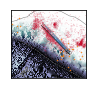

In [4]:
lonmin=-96; lonmax=-93.5; latmin=14; latmax=16.2
def drawbasemap(elon, elat, intlon, intlat):
    m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
            rsphere=(6378137.00,6356752.3142),resolution='i',projection='merc')
    cs=DrawTopography(m, 'data/GEBCO_'+str(lonmin)+'_'+str(lonmax)+'_'+str(latmin)+'_'+str(latmax)+'.grd', 'bone', 0, 1)
    #m.fillcontinents(color='w',zorder=1)
    m.drawparallels(np.arange(-80.,81.,0.5),labels=[0,0,0,0], \
                    fontsize=initfontsize, dashes=(4,10000), color='C7', linewidth=0.5)
    m.drawmeridians(np.arange(-180.,181.,0.5),labels=[0,0,0,0], \
                    fontsize=initfontsize, dashes=(4,10000), color='C7', linewidth=0.5)
    m.drawcoastlines(color='C7', linewidth=0.5)
    m.drawcountries(color='C7', linewidth=0.5)
    return m, cs

w = 1.5; h = 1.5
fig=plt.figure(figsize=(w, h))
ax=fig.add_axes([0.15,0.1,0.7,0.7]) 
#ax.set_xlabel('Longitude', labelpad=12)
#ax.set_ylabel('Latitude', labelpad=28)
elon, elat=-93.715, 15.068
slon, slat=-94.11, 14.85
m, cs=drawbasemap(elon, elat, 2, 1)

data=np.loadtxt('data/plateb_2002Bird_Mexico.txt', delimiter=',')
x, y=m(data[:,0], data[:,1])
ax.plot(x, y, color='C7', linestyle='--', linewidth=0.5)

data=np.loadtxt('data/map_slip_1506522685.NoNaN.txt')
alon=data[:, 0]; alat=data[:, 1]; slip=data[:,2]
xi=np.linspace(alon.min(), alon.max(), 1000)
yi=np.linspace(alat.min(), alat.max(), 1000)
X,Y= np.meshgrid(xi,yi)
X, Y=m(X, Y)
resampled = griddata(alon, alat, slip, xi, yi,'linear')
interval = np.arange(3,slip.max()+3,3)
ax.contour(X, Y, resampled, interval, colors='C0', linewidths=0.3, alpha=1, zorder=18)

data=np.loadtxt('data/FaultModPlane/work/edge_1506522685')
x, y=m(data[:,0], data[:,1])
ax.plot(x, y, color='C7', alpha=0.85, solid_capstyle='round', lw=0.5, zorder=18)
data=np.loadtxt('data/FaultModPlane/work/edge_top_1506522685')
x, y=m(data[:,0], data[:,1])
ax.plot(x, y, color='k', alpha=0.85, solid_capstyle='round', lw=0.5, zorder=18)

data=np.loadtxt('data/jgrb52189-sup-0003-2017JB014188-S02.txt', usecols=(3, 4, 5, 6), skiprows=1)
x, y=m(data[:,0]-360, data[:,1])
dep, mag=(data[:,2], data[:,3])
ax.scatter(x, y, s=2, alpha=0.85, edgecolor='C7', facecolor='C1', zorder=15, lw=0.1)

data=np.loadtxt('data/seismicitySSNfromM3aftershock7th-21th.txt_shaped.txt')
x, y=m(data[:,1], data[:,0])
dep, mag=(data[:,2], data[:,3])
ax.scatter(x, y, s=1, alpha=0.2, edgecolor='none', facecolor='#c8102e', label='UNAM SSN')

lat=[14.9, 14.75, 12.6, 11.5, 10.333333]
lon=[-95.19, -95.333333, -97.5, -98.75, -100.5] #https://www.ngdc.noaa.gov/gazetteer/
x, y=m(lon, lat)
#ax.plot(x, y, color='w', linestyle=':', lw=0.5)
x, y=m(-95.7, 14)
text=ax.text(x, y, 'TFZ', rotation=45, ha='left', va='bottom', color='k', size=6)
text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])

#for i in [44]:
#    g1=geod.Direct(12.6, -97.5, i, 1000*1e3)
#    g2=geod.Direct(12.6, -97.5, i, -1000*1e3)
#    x, y=m([g2['lon2'], g2['lon1'], g1['lon1'], g1['lon2']], [g2['lat2'], g2['lat1'], g1['lat1'], g1['lat2']])
#    ax.plot(x, y, lw=0.1)

#data=np.loadtxt('data/DistanceAlongStrikeFromSSNEpiA316.txt')
#x, y=m(data[:,0], data[:,1])
#ax.scatter(x, y, s=0.1)
    
x, y=m(slon, slat)
ax.scatter(x, y, s=np.exp(8.1*0.4), marker='*', facecolor='none', edgecolor='k', alpha=0.7, lw=0.5, zorder=20)

#axp=ax.get_position()
#x, y=m([lonmin, lonmax], [latmin, latmax])
#aspect=max(x)/max(y)
#cax=fig.add_axes([axp.x1+0.01, 0.5*((axp.y1-axp.y0)-(axp.y1-axp.y0)/aspect)+axp.y0, \
#                  0.02, (axp.y1-axp.y0)/aspect])
#plt.colorbar(cs, cax=cax).set_label('Bathymetry (m)')
plt.savefig('fig/map_meta_enlarge.pdf', bbox_inches="tight", pad_inches=0.0001, transparent=False)
plt.show()

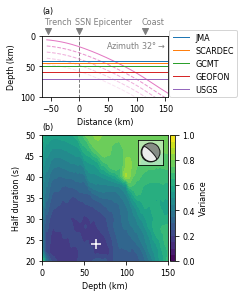

In [18]:
w = 3.5; h = 5.6; wh=w/h
fig=plt.figure(figsize=(w, h))
ax=fig.add_axes([0.2,1.1*wh,0.5,0.5/2.05*wh])
axp1=ax.get_position()
fig.text(axp1.x0, axp1.y1+0.05, '(a)', va='bottom', ha='left')
ax.set_xlim([-65, 155])
ax.set_ylim([0, 100])
ax.set_ylabel('Depth (km)')
ax.set_xlabel('Distance (km)')
ax.set_xticks([-50, 0, 50, 100, 150])
data=np.loadtxt('data/slab1.0projA32SSN.txt')
slon, slat, sdis, sdep=(data[:,0], data[:,1], data[:,2], data[:,3]*-1)
ax.plot(sdis, sdep, color='C6', lw=1)
ax.plot(sdis, sdep+10, color='C6', linestyle='--', alpha=0.8, lw=1)
ax.plot(sdis, sdep+20, color='C6', linestyle='--', alpha=0.6, lw=1)
ax.plot(sdis, sdep+30, color='C6', linestyle='--', alpha=0.4, lw=1)
ax.plot(sdis, sdep+40, color='C6', linestyle='--', alpha=0.2, lw=1)
ax.text(150, 20, r'Azimuth 32$\degree\rightarrow$', size=8, ha='right', color='C7')
x, y, text=([5, 5, 5, 5, 5], [40.9, 44.0, 50.2, 60.0, 70.5], \
            ['JMA', 'SCARDEC', 'GCMT', 'GEOFON', 'USGS'])
for x, y, text in zip(x, y, text):
    ax.plot([-200, 200], [y, y], label=text, lw=1)
x, y, text=([115, -55, 0], [-8, -8, -8], ['Coast', 'Trench', 'SSN Epicenter'])
for x, y, text in zip(x, y, text):
    ax.scatter(x, y, marker='v', clip_on=False, color='C7')
    ax.text(x-7, y-7, text, size=8, va='bottom', ha='left', color='C7')
ax.plot([0, 0], [0, 100], linestyle='--', color='C7', zorder=0, lw=1)
plt.legend(loc=[1.01, 0], fontsize=8)
plt.gca().invert_yaxis()
####################################################################################
ax2=fig.add_axes([axp1.x0,axp1.y0-0.65*wh,axp1.x1-axp1.x0,(axp1.x1-axp1.x0)*wh]) 
axp2=ax2.get_position()
fig.text(axp2.x0, axp2.y1+0.01, '(b)', va='bottom', ha='left')
ax2.set_xlabel('Depth (km)')
ax2.set_ylabel('Half duration (s)')
xmin=0; xmax=150; ymin=20; ymax=50
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymin, ymax])
ax2.set_xticks(np.linspace(0, 150, 4))
data=np.loadtxt('data/CMTsolutionDepthRtimeVarianceSNN.txt', usecols=(3, 4, 5))
depth, rtime, variance=(data[::2,0], data[::2,1], data[::2,2])
x, y, z=(depth, rtime, variance)
xi=np.linspace(xmin, xmax, 100)
yi=np.linspace(ymin, ymax, 100)
X, Y=np.meshgrid(xi, yi)
interp = Rbf(x, y, z, function='linear')
zi = interp(X, Y)
#resampled=griddata(x, y, z, xi, yi,'linear')
interval=np.arange(0,1.05,0.05)
sc1=ax2.contourf(X, Y, zi, interval, vmin=0, vmax=1, cmap='viridis')
ax2.scatter(x[np.argmin(z)], y[np.argmin(z)], color='w', marker='+', s=100)
axp=ax2.get_position()
cax=fig.add_axes([axp.x1+0.008, axp.y0, 0.02, axp.y1-axp.y0])
plt.colorbar(sc1, cax=cax, ticks=np.arange(0, 1.2, 0.2)).set_label('Variance')
from matplotlib.ticker import FormatStrFormatter
cax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
####################################################################################
axb=fig.add_axes([axp2.x1-0.12,axp2.y1-0.12*wh,0.1,0.1*wh])
axb.patch.set_facecolor('w')
axb.patch.set_alpha(0.5)
data=np.loadtxt('data/CMTsolution.txt', usecols=(0, 1, 2, 3, 4, 5, 6, 7, 8))
focmecs=data[:,2:8]
for i in np.arange(0, 1, 1):
    b=beach(focmecs[i].tolist(), xy=(i*5+2.5, 2.5), width=4.5, facecolor='C7', linewidth=1, alpha=0.85)
    axb.add_collection(b).set_zorder(-1)
axb.set_xlim((-0.5, 5.5))
axb.set_ylim((-0.5, 5.5))
axb.set_aspect("equal")
axb.set_xticks([])
axb.set_yticks([])

plt.savefig('fig/focaldepths.jpg', transparent=False, bbox_inches="tight", pad_inches=0.1)
plt.show()

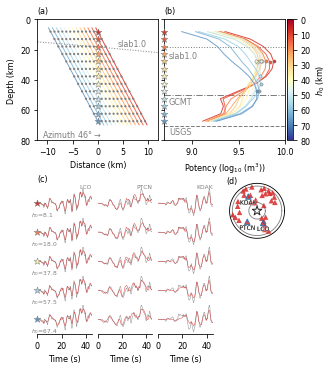

In [19]:
def drawobssyn(ax, obsdata, syndata, alpha):
    data=np.loadtxt(obsdata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C7', lw=0.5, alpha=alpha)
    data=np.loadtxt(syndata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C3', lw=0.5, alpha=alpha)
def fittings(sta, x0, y1, width, height, modelid, dep, mint, maxt, numwave, cmap, maxdepofcolor, flag):
    j=0
    for i in [0, 2, 6, 10, 12]:
        ax=fig.add_axes([x0,y1-height*j,width,height])
        drawobssyn(ax, 'data/obssyn/obs_'+sta+'_'+modelid[i]+'.txt', \
                   'data/obssyn/syn_'+sta+'_'+modelid[i]+'.txt', 0.85)
        color = cmap(dep[i]/maxdepofcolor)
        if flag == 1:
            ax.scatter(0, 0, s=50, marker='*', edgecolor='C7', lw=0.5, zorder=20, color=color, clip_on=False)
            ax.text(-5, -0.5, r'$h_{0}$='+str('%.1f' % dep[i]), ha='left', va='top', \
                    size=6, color='C7', zorder=200, clip_on=False)
        ax.set_xlim([mint, maxt])
        ax.set_ylim([-1, 1])
        if i==0:
            ax.text(maxt, 1, sta, va='bottom', ha='right', size=6, color='C7', clip_on=False)
        #if i==numwave-1:
        if i==12:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([0, 20, 40])
            ax.set_xticklabels([0, 20, 40])
            ax.set_xlabel('Time (s)')
            ax.set_yticklabels([])
            ax.set_yticks([])
        else:
            ax.set_axis_off()
        j+=1
    return ax
modeltype='DepthSSNFinal170928'
modellist='data/SlipModelList'+modeltype+'.txt'
w = 5.6; h = 5.6; wh=w/h
fig=plt.figure(figsize=(w, h))
ax=fig.add_axes([0.1,0.65, 0.3,0.3])
axp1=ax.get_position()
fig.text(axp1.x0, axp1.y1+0.01, '(a)', va='bottom', ha='left')
ax.set_xlim([-12, 12])
maxdepofcolor=80
ax.set_ylim([0, maxdepofcolor])
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (km)')
data=np.loadtxt('data/slab1.0projA46SSN.txt')
slon, slat, sdis, sdep=(data[:,0], data[:,1], data[:,2], data[:,3]*-1)
ax.plot(sdis, sdep, color='C7', linestyle=':', lw=1)
dip=81.0; dk=5; k0ref=11; refdep=18
k=np.arange(1, 14, 1)
cmap=plt.get_cmap('RdYlBu')
for k0 in np.arange(13, 0, -1):
    dep0=refdep+np.sin(dip*np.pi/180)*(dk*(k0ref-k0))
    dep=dep0+np.sin(dip*np.pi/180)*(dk*(k0-k))
    x=dk*(k0-k)*np.cos(dip*np.pi/180)
    color = cmap(dep0/maxdepofcolor)
    ax.scatter(x, dep, facecolor='C7',s=5, edgecolor='none', zorder=3)
    ax.scatter(0, dep0, s=50, marker='*', edgecolor='C7', lw=0.5, zorder=20, color=color)
    #print(k0, str('%.2f' % dep0), '81.0', '316.0', '3.0')
    k2=np.arange(1, 28, 1)
    k02=k0*2
    dep=dep0+np.sin(dip*np.pi/180)*(2.5*(k02-k2))
    x=2.5*(k02-k2)*np.cos(dip*np.pi/180)
    ax.plot(x, dep, color=color, zorder=0, lw=1, alpha=0.85)
ax.text(4, 18, 'slab1.0', size=8, color='C7')
ax.text(-11, 78, r'Azimuth 46$\degree\rightarrow$', size=8, color='C7', ha='left')
plt.gca().invert_yaxis()
##################################################################################
axp=ax.get_position()
ax=fig.add_axes([axp.x1+0.015, axp.y0, axp.x1-axp.x0, axp.y1-axp.y0])
axp2=ax.get_position()
fig.text(axp2.x0, axp2.y1+0.01, '(b)', va='bottom', ha='left')
xmin=8.7; xmax=10
ax.set_xlim([xmin, xmax])
ax.set_ylim([0, maxdepofcolor])
ax.set_xlabel(r'Potency ($\log_{10}$ (m$^{3}$))')
ax.set_ylabel(''); ax.set_yticklabels([])
data=np.loadtxt('data/slab1.0projA46SSN_-12_12_0.01.txt')
slabdep=data[:,3]*-1
ax.plot([xmin, xmax],[slabdep.mean(), slabdep.mean()], linestyle=':', lw=1, color='C7')
wphaseusgs=70.5; gcmt=50.2; jma=49.0
ax.plot([xmin, xmax], [gcmt, gcmt], color='C7', linestyle='-.', lw=1)
ax.plot([xmin, xmax], [wphaseusgs, wphaseusgs], color='C7', linestyle='--', lw=1)
file=np.genfromtxt(modellist, usecols=(0), dtype=('str'))
for i in np.arange(0, len(file), 1):
    data=np.loadtxt('data/potency_'+str(file[i])+'.txt')
    dep, pot, dep0=(data[:,1], data[:,2], data[:,3])
    color = cmap(dep0[0]/maxdepofcolor)
    ax.plot(pot, dep, color=color, lw=1, alpha=0.85)
    ax.scatter(xmin, dep0[0], s=50, marker='*', edgecolor='C7', lw=0.5, zorder=20, color=color, clip_on=False)
    ax.scatter(pot[np.argmax(pot)], dep[np.argmax(pot)], facecolor=color, zorder=30, s=10, edgecolor='C7', lw=0.5)
    #print(pot[np.argmax(pot)], dep[np.argmax(pot)], dep0[0])
ax.text(xmin+0.05, 21, 'slab1.0', size=8, color='C7', va='top')
ax.text(xmin+0.05, 56, 'GCMT', size=8, color='C7')
ax.text(xmin+0.05, 76, 'USGS', size=8, color='C7')
plt.gca().invert_yaxis()
##################################################################################
axp=ax.get_position()
cax=fig.add_axes([axp.x1+0.005, axp.y0, 0.015, axp.y1-axp.y0])
norm=mpl.colors.Normalize(vmin=0, vmax=maxdepofcolor)
cb=mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, alpha=0.85)
cb.set_label('$h_{0}$ (km)')
plt.gca().invert_yaxis()
##################################################################################
modelid=np.loadtxt(modellist, usecols=(0), dtype=str)
dep=np.loadtxt(modellist, usecols=(3))
width=0.135; height=(axp1.y1-axp1.y0)/5*1.2; mint=0; maxt=45; numwave=len(modelid); y1=axp1.y0-0.12
sta='LCO'; x0=axp1.x0
fig.text(x0, y1+0.015, '(c)', va='bottom', ha='left')
ax=fittings(sta, x0, y1-height, width, height, modelid, dep, mint, maxt, numwave, cmap, maxdepofcolor, 1)

axp4=ax.get_position()
sta='PTCN'; x0=axp4.x1+0.015
ax=fittings(sta, x0, y1-height, width, height, modelid, dep, mint, maxt, numwave, cmap, maxdepofcolor, 0)

axp5=ax.get_position()
sta='KDAK'; x0=axp5.x1+0.015
ax=fittings(sta, x0, y1-height, width, height, modelid, dep, mint, maxt, numwave, cmap, maxdepofcolor, 0)
##################################################################################
y1=axp1.y0-0.12
ax=fig.add_axes([0.57, axp1.y0-0.25, 0.15, 0.15])
axp=ax.get_position()
fig.text(axp.x0, y1+0.01, '(d)', va='bottom', ha='left')
ax=stamap(ax, 'data/station.list')
a, d, sta=([90-328.5, 90-153.2, 90-221.9],[60.9, 49.1, 53.4], ['KDAK', 'LCO', 'PTCN'])
for a, d, sta in zip(a, d, sta):
    x, y=(d*np.cos(a*np.pi/180.0), d*np.sin(a*np.pi/180.0))
    ax.scatter(x, y, s=30, marker='^', edgecolor='C0', facecolor='none', alpha=0.85)
    text=ax.text(x, y-15, sta, size=6, color='k', va='top', ha='center')
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), \
                           path_effects.Normal()])

plt.savefig('fig/modelsettingresults.jpg', bbox_inches="tight", pad_inches=0.1, transparent=False)
plt.show()

1506522685


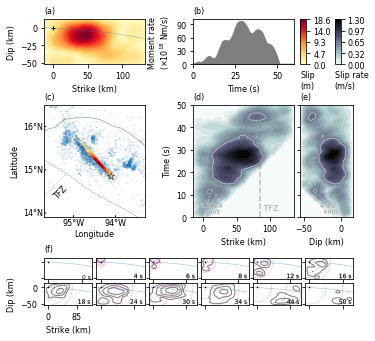

In [20]:
modellist='data/SlipModelListDepthSSNFinal170928.txt'
iddata=np.loadtxt(modellist, usecols=(0), dtype=str)
data=np.loadtxt(modellist)
strdata, dipdata, depdata=(data[:,1], data[:,2], data[:,3])
j=2
modelid=iddata[j]
strikeforslab=np.int(strdata[j])
print(modelid)
def deptodip(ax, data, h0, dip):
    data=np.loadtxt(data)
    x, h=(data[:,2], data[:,3]*-1)
    y=(h0-h)/np.cos((90-dip)*np.pi/180)
    ax.plot(x, y, linewidth=0.5, alpha=0.5, color='C0')
###########################################################################################
w = 5.6; h = 5.6; wh=w/h
fig=plt.figure(figsize=(w, h))
data=np.loadtxt('data/sliprake_'+str(modelid))
strike, dip, slip, rake=(data[:,0], data[:,1], data[:,2], data[:,3])
minx=min(strike)-2.5; maxx=max(strike)+2.5
miny=min(dip)-2.5; maxy=max(dip)+2.5
axw=0.25; axh=0.25*(maxy-miny)/(maxx-minx)
ax1=fig.add_axes([0.12,0.8,axw,axh])
axp1=ax1.get_position()
fig.text(axp1.x0, axp1.y1+0.01, '(a)', va='bottom', ha='left')
ax1.set_xlim([minx, maxx])
ax1.set_ylim([miny, maxy])
ax1.set_xlabel('Strike (km)')
ax1.set_ylabel('Dip (km)')
ax1.set_xticks([0, 50, 100])
ax1.set_yticks([-50, -25, 0])
xi=np.linspace(minx, maxx, 100)
yi=np.linspace(miny, maxy, 100)
X, Y=np.meshgrid(xi, yi)
interp = Rbf(strike, dip, slip, function='linear')
zislip = interp(X, Y)
interval=np.linspace(0,zislip.max(),51)
sc1=ax1.contourf(X, Y, zislip, interval, vmin=0, vmax=zislip.max(), cmap='YlOrRd')
ax1.scatter(0, 0, color='k', marker='+', zorder=10, s=12, lw=1)
#zscale=slip*1.5
#ax1.quiver(strike, dip, np.cos(rake*np.pi/180.0)*zscale, np.sin(rake*np.pi/180.0)*zscale, \
#              units='x', width=0.7, scale=1/0.6, clip_on=False, alpha=0.5, color='k', zorder=5, minlength=0)
deptodip(ax1, 'data/slab1.0proj'+str(np.int(strdata[j]))+'SSN.txt', depdata[j], dipdata[j])
###########################################################################################
ax2=fig.add_axes([axp1.x1+0.12, axp1.y0, axp1.x1-axp1.x0, axp1.y1-axp1.y0])
axp2=ax2.get_position()
fig.text(axp2.x0, axp2.y1+0.01, '(b)', va='bottom', ha='left')
ax2.set_xlim([0, 60])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Moment rate'+'\n'+r'($\times 10^{18}$ Nm/s)')
data=np.loadtxt('data/st_'+str(modelid)+'.dat')
time, mo=(data[:,0], data[:,1])
ax2.fill_between(time, 0, mo, color='C7')
ax2.plot(time, mo, color='C7')
ax2.set_ylim([0, max(mo)+5])
ax2.set_xticks(np.arange(0, 75, 25))
ax2.set_yticks(np.arange(0, max(mo), 30))
###########################################################################################   
lonmin=-95.7; lonmax=-93.3; latmin=13.9; latmax=16.5
m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
        rsphere=(6378137.00,6356752.3142),resolution='i',projection='merc')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=max(x)/max(y)
mapwidth=axp1.x1-axp1.x0; mapheight=mapwidth/aspect
ax3=fig.add_axes([axp1.x0, axp1.y0-mapheight-0.1, mapwidth, mapheight])
axp3=ax3.get_position()
fig.text(axp3.x0, axp3.y1+0.01, '(c)', va='bottom', ha='left')
m.drawparallels(np.arange(-80.,81.,1),labels=[1,0,0,0], fontsize=initfontsize, \
                dashes=(2,10000), color='k')
m.drawmeridians(np.arange(-180.,181.,1),labels=[0,0,0,1], fontsize=initfontsize, \
                dashes=(2,10000), color='k')
m.drawcoastlines(color='C7', linewidth=0.5)
m.drawcountries(color='C7', linewidth=0.5)
#x, y=m([-95, -95],[latmax, latmax-0.05])
#ax3.plot(x, y, lw=1, color='k')
#x, y=m([-94, -94],[latmax, latmax-0.05])
#ax3.plot(x, y, lw=1, color='k')
#x, y=m(-95, latmax+0.03)
#ax3.text(x, y, r'95$\degree$W', ha='center', va='bottom')
#x, y=m(-94, latmax+0.03)
#ax3.text(x, y, r'94$\degree$W', ha='center', va='bottom')

ax3.set_xlabel('Longitude', labelpad=12)
#ax3.get_xaxis().set_label_position('top')
ax3.set_ylabel('Latitude', labelpad=25)
elon, elat=-93.715, 15.068
slon, slat=-94.11, 14.85
lonmin=-95.8; lonmax=-93.3; latmin=13.9; latmax=16.5
data=np.loadtxt('data/plateb_2002Bird_Mexico.txt', delimiter=',')
x, y=m(data[:,0], data[:,1])
ax3.plot(x, y, color='C7', linestyle='--', linewidth=0.5)
data=np.loadtxt('data/map_slip_'+str(modelid)+'.NoNaN.txt')
alon=data[:, 0]; alat=data[:, 1]; mapslip=data[:,2]
xi=np.linspace(alon.min(), alon.max(), 1000)
yi=np.linspace(alat.min(), alat.max(), 1000)
X,Y= np.meshgrid(xi,yi)
X, Y=m(X, Y)
resampled = griddata(alon, alat, mapslip, xi, yi,'linear')
interval = np.arange(3,max(mapslip)+3,3)
sc=ax3.contourf(X, Y, resampled, interval, vmin=0, vmax=max(mapslip), cmap='YlOrRd', alpha=0.85)
data=np.loadtxt('data/FaultModPlane/faultedgestr316dip'+str(np.int(dipdata[j]))+'.txt')
data=np.loadtxt('data/FaultModPlane/work/edge_'+str(modelid))
x, y=m(data[:,0], data[:,1])
ax3.plot(x, y, color='C7', alpha=0.85, solid_capstyle='round', lw=0.3)
data=np.loadtxt('data/FaultModPlane/work/edge_top_'+str(modelid))
x, y=m(data[:,0], data[:,1])
ax3.plot(x, y, color='k', alpha=0.85, solid_capstyle='round', lw=0.3)
data=np.loadtxt('data/seismicitySSNfromM3aftershock7th-21th.txt_shaped.txt')
x, y=m(data[:,1], data[:,0])
dep, mag=(data[:,2], data[:,3])
ax3.scatter(x, y, s=2, alpha=0.2, edgecolor='none', facecolor='C0', label='UNAM SSN', zorder=0)
lat=[14.9, 14.75, 12.6, 11.5, 10.333333]
lon=[-95.19, -95.333333, -97.5, -98.75, -100.5] #https://www.ngdc.noaa.gov/gazetteer/
x, y=m(lon, lat)
ax3.plot(x, y, color='C7', linestyle=':', linewidth=0.5)
x, y=m(slon, slat)
ax3.scatter(x, y, s=np.exp(8.1*0.5), marker='*', facecolor='none', edgecolor='k', alpha=0.85, lw=0.5, zorder=20)
x, y=m(-95.5, 14.3)
text=ax3.text(x, y, 'TFZ', rotation=45, ha='left', va='bottom', color='k', size=8)
#text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])
###########################################################################################   
strdata=np.loadtxt('data/slipevostrike.txt')
dipdata=np.loadtxt('data/slipevodip.txt')
cmap='bone_r'
x, z, y=(strdata[:,0], strdata[:,1], strdata[:,2]-1)
xi=np.linspace(min(x), max(x), 100)
yi=np.linspace(min(y), max(y), 100)
strikewidth=max(x)-min(y)
X, Y=np.meshgrid(xi, yi)
zi=griddata(x, y, z, xi, yi,'linear')
interval=np.linspace(-0.001, zi.max(), 21)
ax4=fig.add_axes([axp2.x0, axp3.y0, axp2.x1-axp2.x0, axp3.y1-axp3.y0])
axp4=ax4.get_position()
fig.text(axp4.x0, axp4.y1+0.01, '(d)', va='bottom', ha='left')
ax4.set_xlabel('Strike (km)')
ax4.set_ylabel('Time (s)')
ax4.set_xlim([min(x), max(x)])
ax4.set_ylim([0, 50])
xticks=np.arange(0, 150, 50)
ax4.set_xticks(xticks)
ax4.set_xticklabels(xticks)
sc4=ax4.contourf(X, Y, zi, interval, vmin=0, vmax=zi.max(), cmap=cmap)
ax4.contour(X, Y, zi, np.arange(zi.max()*0.5, zi.max()*0.51, 1), colors='w', linewidths=0.5, alpha=0.85)
for i in np.arange(1, 5, 1):
    duration=10; initx=0
    ax4.plot([initx, initx+i*duration], [0, duration], color='w', alpha=0.5, lw=0.5)
text=ax4.text(-3, 6, '1 2 3 4\n  km/s', size=6, \
         va='top', ha='left', color='C7', alpha=0.85) 
text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])
ax4.plot([85, 85],[0, 100], color='C7', linestyle='--', alpha=0.5)
text=ax4.text(90, 2, 'TFZ', color='C7', ha='left', va='bottom', alpha=0.5, size=8)
text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])
#rect=plt.Rectangle((70, 0), 10, 100, color='C7', alpha=0.2, lw=0)
#ax1.add_patch(rect).set_zorder(10)
#for i in np.arange(-10, 200, 10):
#    ax1.plot([i, i],[0, 50], lw=0.5, color='k')
#    ax1.plot([-50, 200],[i/2, i/2], lw=0.5, color='k')
#####################################################################################
x, z, y=(dipdata[:,0], dipdata[:,1], dipdata[:,2]-1)
xi=np.linspace(min(x), max(x), 100)
yi=np.linspace(min(y), max(y), 100)
dipwidth=(max(x)-min(x))
X, Y=np.meshgrid(xi, yi)
zi=griddata(x, y, z, xi, yi,'linear')
interval=np.linspace(-0.001, zi.max(), 21)
ax5=fig.add_axes([axp4.x1+0.015,axp4.y0,(axp4.x1-axp4.x0)*dipwidth/strikewidth,axp4.y1-axp4.y0])
axp5=ax5.get_position()
fig.text(axp5.x0, axp5.y1+0.01, '(e)', va='bottom', ha='left')
ax5.set_xlabel('Dip (km)')
ax5.set_xlim([min(x), max(x)])
ax5.set_ylim([0, 50])
ax5.set_yticklabels([])
sc5=ax5.contourf(X, Y, zi, interval, vmin=0, vmax=zi.max(), cmap=cmap)
ax5.contour(X, Y, zi, np.arange(zi.max()*0.5, zi.max()*0.51, 1), colors='w', linewidths=0.5, alpha=0.85)
for i in np.arange(1, 5, 1):
    duration=10; initx=0
    ax5.plot([initx, initx+i*duration*-1], [0, duration], color='w', alpha=0.5, lw=0.5)
text=ax5.text(-28, 6, '4 3 2 1\n  km/s', size=6, \
         va='top', ha='left', color='C7', alpha=0.85) 
text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='w'), path_effects.Normal()])
###########################################################################################
data=np.loadtxt('data/snap_'+str(modelid)+'/anim/fort.601')
x, y, slip=(data[:,0], data[:,1], data[:,4])
maxslip=2.0; intslip=0.26
axw=0.1195; axh=axw*(maxy-miny)/(maxx-minx)
ax=fig.add_axes([axp3.x0,axp5.y0-0.1-axh,axw,axh])
axp=ax.get_position()
fig.text(axp.x0, axp.y1+0.01, '(f)', va='bottom', ha='left')
fig.text(axp.x1-0.005, axp.y0, '0 s', size=6, va='bottom', ha='right')
ax.set_xticklabels([])
ax.set_yticklabels([])
sc=gensnap(ax, 'data/snap_'+str(modelid)+'/anim/fort.601', maxslip, intslip, minx, maxx, miny, maxy)
deptodip(ax, 'data/slab1.0proj316SSN.txt', 18.0, 81.0)
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])
#for i in np.arange(601, 651, 1):
#for i in [604, 618]:
for i in [604, 606, 608, 612, 616, 618, 624, 630, 634, 644, 650]:
    if i == 618:
        axp=ax.get_position()
        ax=fig.add_axes([axp1.x0, axp.y0-axh-0.01, axw, axh])
        ax.set_xlabel('Strike (km)')
        ax.set_xticks([0, 85])
        ax.set_ylabel('Dip (km)')
    elif i > 618:
        axp=ax.get_position()
        ax=fig.add_axes([axp.x1+0.01, axp.y0, axw, axh])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        axp=ax.get_position()
        ax=fig.add_axes([axp.x1+0.01, axp.y0, axw, axh])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    axp=ax.get_position()
    text=fig.text(axp.x1-0.005, axp.y0, str(i-600)+' s', size=6, va='bottom', ha='right')
    text.set_path_effects([path_effects.Stroke(linewidth=0.3, foreground='w'), path_effects.Normal()])
    sc=gensnap(ax, 'data/snap_'+str(modelid)+'/anim/fort.'+str(i), maxslip, intslip, minx, maxx, miny, maxy)
    theta=np.arange(0, 360, 1)
    for vr in [1, 2, 3, 4]:
        x=vr*np.cos(theta*np.pi/180)*(i-600)
        y=vr*np.sin(theta*np.pi/180)*(i-600)
        ax.plot(x, y, linestyle='--', color='C6', alpha=0.85, linewidth=0.5)
    deptodip(ax, 'data/slab1.0proj316SSN.txt', 18.0, 81.0)
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])
###########################################################################################
axp=ax2.get_position()
cax=fig.add_axes([axp5.x0, axp.y0, 0.015, axp.y1-axp.y0])
fig.text(axp5.x0, axp.y0-0.015, 'Slip\n(m)', ha='left', va='top')
cbar=plt.colorbar(sc1, cax=cax, ticks=np.linspace(0, zislip.max(), 5), format='%.1f')

cax=fig.add_axes([axp.x1+0.1, axp.y0, 0.015, axp.y1-axp.y0])
fig.text(axp.x1+0.1, axp.y0-0.015, 'Slip rate\n(m/s)', ha='left', va='top')
cbar=plt.colorbar(sc5, cax=cax, ticks=np.linspace(0, zi.max(), 5), format='%.2f')

plt.savefig('fig/slipsummary.jpg', transparent=False, bbox_inches="tight", pad_inches=0.1)
plt.show()

1506505260


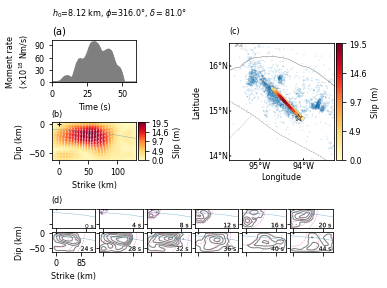

1506513904


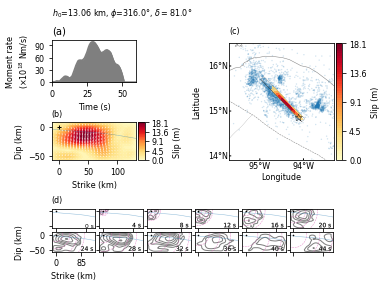

1506522685


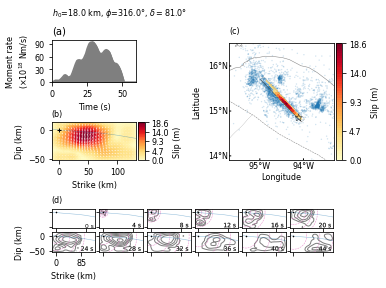

1506531592


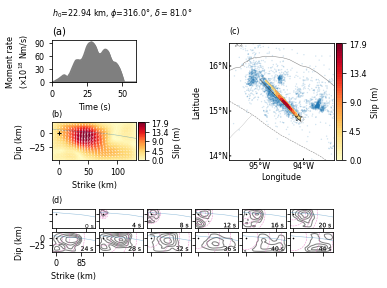

1506540781


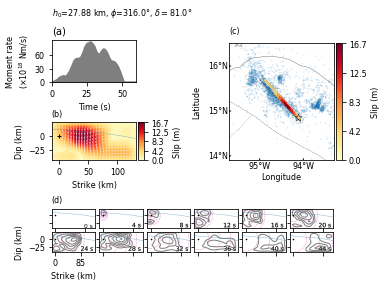

1506505230


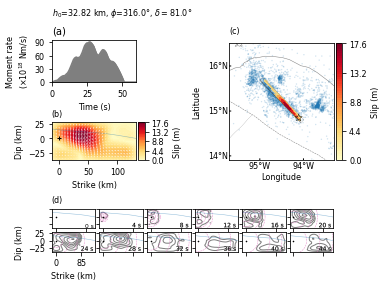

1506513245


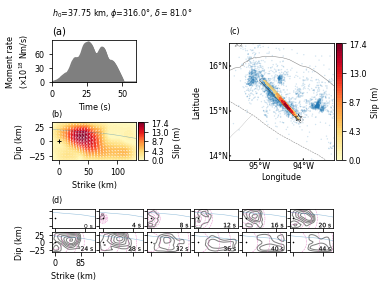

1506521287


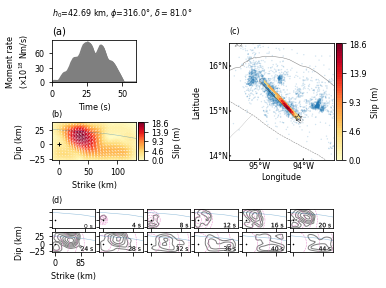

1506529299


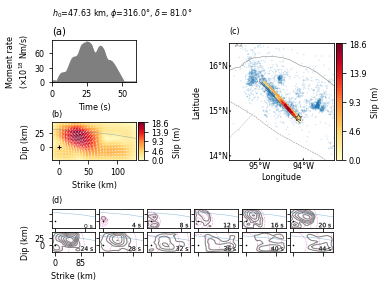

1506537367


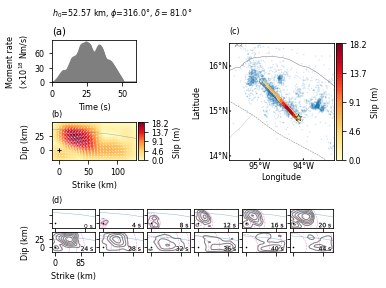

1506545071


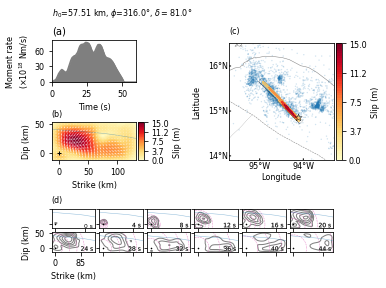

1506552765


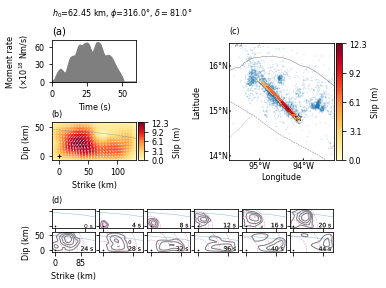

1506560422


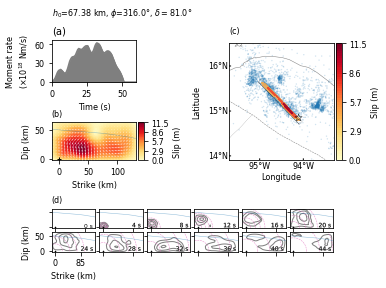

In [13]:
modellist='data/SlipModelListDepthSSNFinal170928.txt'
#modellist='data/SlipModelListDipSSNFinal170928.txt'
#modellist='data/SlipModelListStrikeSSNFinal170928.txt'
#modellist='data/SlipModelListAltStructureSSNFinal170928.txt'
iddata=np.loadtxt(modellist, usecols=(0), dtype=str)
data=np.loadtxt(modellist)
strdata, dipdata, depdata=(data[:,1], data[:,2], data[:,3])
#for j in np.arange(2, 3, 1):
for j in np.arange(0, len(iddata), 1):
    modelid=iddata[j]
    print(modelid)
    def deptodip(ax, data, h0, dip):
        data=np.loadtxt(data)
        x, h=(data[:,2], data[:,3]*-1)
        y=(h0-h)/np.cos((90-dip)*np.pi/180)
        ax.plot(x, y, linewidth=0.5, alpha=0.5, color='C0')
###########################################################################################
    w = 5.6; h = 5.6; wh=w/h
    fig=plt.figure(figsize=(w, h))
    data=np.loadtxt('data/sliprake_'+str(modelid))
    strike, dip, slip, rake=(data[:,0], data[:,1], data[:,2], data[:,3])
    minx=min(strike)-2.5; maxx=max(strike)+2.5
    miny=min(dip)-2.5; maxy=max(dip)+2.5
    axw=0.21; axh=0.21*(maxy-miny)/(maxx-minx)
    ax1=fig.add_axes([0.15,0.5,axw,axh])
    axp1=ax1.get_position()
    fig.text(axp1.x0, axp1.y1+0.01, '(b)', va='bottom', ha='left')
    ax1.set_xlim([minx, maxx])
    ax1.set_ylim([miny, maxy])
    ax1.set_xlabel('Strike (km)')
    ax1.set_ylabel('Dip (km)')
    ax1.set_xticks([0, 50, 100])
    xi=np.linspace(minx, maxx, 100)
    yi=np.linspace(miny, maxy, 100)
    X, Y=np.meshgrid(xi, yi)
    interp = Rbf(strike, dip, slip, function='linear')
    zi = interp(X, Y)
    interval=np.linspace(0,zi.max(),51)
    sc1=ax1.contourf(X, Y, zi, interval, vmin=0, vmax=max(slip), cmap='YlOrRd')
    ax1.scatter(0, 0, color='k', marker='+', zorder=10, s=12, lw=1)
    zscale=slip*1.5
    ax1.quiver(strike, dip, np.cos(rake*np.pi/180.0)*zscale, np.sin(rake*np.pi/180.0)*zscale, \
                  units='x', width=0.7, scale=1/0.5, clip_on=False, alpha=0.85, color='w', zorder=5, minlength=0)
    deptodip(ax1, 'data/slab1.0proj'+str(np.int(strdata[j]))+'SSN.txt', depdata[j], dipdata[j])
###########################################################################################
    axp=ax1.get_position()
    cax=fig.add_axes([axp.x1+0.005, axp.y0, 0.015, axp.y1-axp.y0])
    cbar=plt.colorbar(sc1, cax=cax, ticks=np.linspace(0, zi.max(), 5), format='%.1f').set_label('Slip (m)')
###########################################################################################
    ax2=fig.add_axes([axp1.x0, axp1.y1+0.1, axp1.x1-axp1.x0, (axp1.x1-axp1.x0)*0.5])
    axp2=ax2.get_position()
#    fig.text(axp2.x0, axp2.y1+0.09, \
#             'Near-source velocity model from Santoya et al., 2005 (Table S1)', va='bottom', ha='left')
#    fig.text(axp2.x0, axp2.y1+0.09, \
#             'Near-source velocity model from Rebollar et al., 1999a (Table S2)', va='bottom', ha='left')
#    fig.text(axp2.x0, axp2.y1+0.09, \
#             'Near-source velocity model from CRUST1.0 (Laske et al., 2013) (Table S3)', va='bottom', ha='left')

    fig.text(axp2.x0, axp2.y1+0.05, \
             r'$h_{0}$='+str(depdata[j])+r' km, $\phi$='\
             +str(strdata[j])+r'$\degree$, $\delta=$'+str(dipdata[j])+'$\degree$', va='bottom', ha='left')
    fig.text(axp2.x0, axp2.y1+0.01, \
             '(a)', \
             size=10, va='bottom', ha='left')
    ax2.set_xlim([0, 60])
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Moment rate'+'\n'+r'($\times 10^{18}$ Nm/s)')
    data=np.loadtxt('data/st_'+str(modelid)+'.dat')
    time, mo=(data[:,0], data[:,1])
    ax2.fill_between(time, 0, mo, color='C7')
    ax2.plot(time, mo, color='C7')
    ax2.set_ylim([0, max(mo)+5])
    ax2.set_xticks(np.arange(0, 75, 25))
    ax2.set_yticks(np.arange(0, max(mo), 30))
###########################################################################################   
    lonmin=-95.7; lonmax=-93.3; latmin=13.9; latmax=16.5
    m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,\
            rsphere=(6378137.00,6356752.3142),resolution='i',projection='merc')
    x, y=m([lonmin, lonmax], [latmin, latmax])
    aspect=max(x)/max(y)
    ax3=fig.add_axes([axp1.x1+0.23,axp1.y0,0.26,0.26/aspect])
    axp3=ax3.get_position()
    fig.text(axp3.x0, axp2.y1+0.01, '(c)', va='bottom', ha='left')
    m.drawparallels(np.arange(-80.,81.,1),labels=[1,0,0,0], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')
    m.drawmeridians(np.arange(-180.,181.,1),labels=[0,0,0,1], fontsize=initfontsize, \
                    dashes=(2,10000), color='k')
    m.drawcoastlines(color='C7', linewidth=0.5)
    m.drawcountries(color='C7', linewidth=0.5)
    ax3.set_xlabel('Longitude', labelpad=12)
    ax3.set_ylabel('Latitude', labelpad=28)
    elon, elat=-93.715, 15.068
    slon, slat=-94.11, 14.85
    lonmin=-95.8; lonmax=-93.3; latmin=13.9; latmax=16.5
    data=np.loadtxt('data/plateb_2002Bird_Mexico.txt', delimiter=',')
    x, y=m(data[:,0], data[:,1])
    ax3.plot(x, y, color='C7', linestyle='--', linewidth=0.5)
    data=np.loadtxt('data/map_slip_'+str(modelid)+'.NoNaN.txt')
    alon=data[:, 0]; alat=data[:, 1]; mapslip=data[:,2]
    xi=np.linspace(alon.min(), alon.max(), 1000)
    yi=np.linspace(alat.min(), alat.max(), 1000)
    X,Y= np.meshgrid(xi,yi)
    X, Y=m(X, Y)
    resampled = griddata(alon, alat, mapslip, xi, yi,'linear')
    interval = np.arange(3,max(mapslip)+3,3)
    sc=ax3.contourf(X, Y, resampled, interval, vmin=0, vmax=max(mapslip), cmap='YlOrRd', alpha=0.85)
    #data=np.loadtxt('data/FaultModPlane/faultedgestr316dip'+str(np.int(dipdata[j]))+'.txt')
    data=np.loadtxt('data/FaultModPlane/work/edge_'+str(modelid))
    x, y=m(data[:,0], data[:,1])
    ax3.plot(x, y, color='C7', alpha=0.85, solid_capstyle='round', lw=0.3)
    data=np.loadtxt('data/FaultModPlane/work/edge_top_'+str(modelid))
    x, y=m(data[:,0], data[:,1])
    ax3.plot(x, y, color='k', alpha=0.85, solid_capstyle='round', lw=0.3)
    data=np.loadtxt('data/seismicitySSNfromM3aftershock7th-21th.txt_shaped.txt')
    x, y=m(data[:,1], data[:,0])
    dep, mag=(data[:,2], data[:,3])
    ax3.scatter(x, y, s=2, alpha=0.2, edgecolor='none', facecolor='C0', label='UNAM SSN', zorder=0)
    lat=[14.9, 14.75, 12.6, 11.5, 10.333333]
    lon=[-95.19, -95.333333, -97.5, -98.75, -100.5] #https://www.ngdc.noaa.gov/gazetteer/
    x, y=m(lon, lat)
    ax3.plot(x, y, color='C7', linestyle=':', linewidth=0.5)
    x, y=m(slon, slat)
    ax3.scatter(x, y, s=np.exp(8.1*0.5), marker='*', facecolor='none', edgecolor='k', alpha=0.85, lw=0.5, zorder=20)
###########################################################################################   
    axp=ax3.get_position()
    cax=fig.add_axes([axp.x1+0.005, axp.y0, 0.015, axp.y1-axp.y0])
    plt.colorbar(sc1, cax=cax, ticks=np.linspace(0, zi.max(), 5), format='%.1f').set_label('Slip (m)')
###########################################################################################
    data=np.loadtxt('data/snap_'+str(modelid)+'/anim/fort.601')
    x, y, slip=(data[:,0], data[:,1], data[:,4])
    maxslip=2.0; intslip=0.2
    axw=0.108; axh=0.108*(maxy-miny)/(maxx-minx)
    ax=fig.add_axes([axp1.x0,axp1.y0-0.12-axh,axw,axh])
    axp=ax.get_position()
    fig.text(axp.x0, axp.y1+0.01, '(d)', va='bottom', ha='left')
    fig.text(axp.x1-0.005, axp.y0, '0 s', size=6, va='bottom', ha='right')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    sc=gensnap(ax, 'data/snap_'+str(modelid)+'/anim/fort.601', maxslip, intslip, minx, maxx, miny, maxy)
    deptodip(ax, 'data/slab1.0proj'+str(np.int(strdata[j]))+'SSN.txt', depdata[j], dipdata[j])
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])
    for i in np.arange(604, 648, 4):
        if i == 624:
            axp=ax.get_position()
            ax=fig.add_axes([axp1.x0, axp.y0-axh-0.01, axw, axh])
            ax.set_xlabel('Strike (km)')
            ax.set_xticks([0, 85])
            ax.set_ylabel('Dip (km)')
        elif i > 624:
            axp=ax.get_position()
            ax=fig.add_axes([axp.x1+0.01, axp.y0, axw, axh])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            axp=ax.get_position()
            ax=fig.add_axes([axp.x1+0.01, axp.y0, axw, axh])
            ax.set_yticklabels([])
            ax.set_xticklabels([])
        axp=ax.get_position()
        text=fig.text(axp.x1-0.005, axp.y0, str(i-600)+' s', size=6, va='bottom', ha='right')
        text.set_path_effects([path_effects.Stroke(linewidth=0.3, foreground='w'), path_effects.Normal()])
        sc=gensnap(ax, 'data/snap_'+str(modelid)+'/anim/fort.'+str(i), maxslip, intslip, minx, maxx, miny, maxy)
        theta=np.arange(0, 360, 1)
        for vr in [1, 2, 3, 4]:
            x=vr*np.cos(theta*np.pi/180)*(i-600)
            y=vr*np.sin(theta*np.pi/180)*(i-600)
            ax.plot(x, y, linestyle='--', color='C6', alpha=0.85, linewidth=0.5)
        deptodip(ax, 'data/slab1.0proj'+str(np.int(strdata[j]))+'SSN.txt', depdata[j], dipdata[j])
        ax.set_xlim([minx, maxx])
        ax.set_ylim([miny, maxy])
    plt.savefig('fig/altslip_'+str(modelid)+'.jpg', bbox_inches="tight", \
                pad_inches=0.1, transparent=False)
    #plt.savefig('fig/altslip_'+str(modelid)+'_Santoya2005GI_TableS1.jpg', bbox_inches="tight", \
    #            pad_inches=0.1, transparent=False)
    #plt.savefig('fig/altslip_'+str(modelid)+'_Rebollar1999GI_TableS2.jpg', bbox_inches="tight", \
    #            pad_inches=0.1, transparent=False)
    #plt.savefig('fig/altslip_'+str(modelid)+'_CRUST1.0_TableS3.jpg', bbox_inches="tight", \
    #            pad_inches=0.1, transparent=False)
    plt.show()

KBS 1/34
KEV 2/34
SFJD 3/34
BORG 4/34
KONO 5/34
ESK 6/34
BFO 7/34
PAB 8/34
BBSR 9/34
CMLA 10/34
MACI 11/34
SAML 12/34
LVC 13/34
NNA 14/34
HOPE 15/34
TRQA 16/34
LCO 17/34
EFI 18/34
PTCN 19/34
RAR 20/34
AFI 21/34
FUNA 22/34
XMAS 23/34
JOHN 24/34
MIDW 25/34
ADK 26/34
PET 27/34
COR 28/34
KDAK 29/34
MA2 30/34
COLA 31/34
RSSD 32/34
TIXI 33/34
FFC 34/34


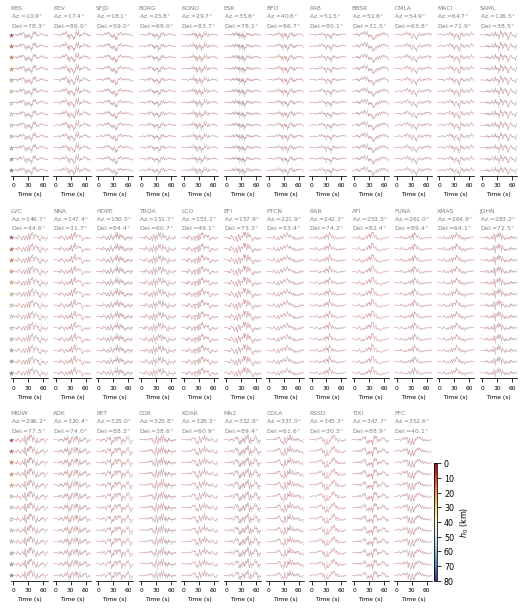

In [21]:
def drawobssyn(ax, obsdata, syndata, alpha):
    data=np.loadtxt(obsdata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C7', lw=0.2, alpha=alpha)
    data=np.loadtxt(syndata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C3', lw=0.2, alpha=alpha)
def fittings(sta, x0, y1, width, height, modelid, dep, mint, maxt, numwave, cmap, maxdepofcolor, flag, azi, dis):
    j=0
    for i in np.arange(0, len(modelid), 1):
        ax=fig.add_axes([x0,y1-height*j,width,height])
        drawobssyn(ax, 'data/obssyn/obs_'+sta+'_'+modelid[i]+'.txt', \
                   'data/obssyn/syn_'+sta+'_'+modelid[i]+'.txt', 0.85)
        cmap=plt.get_cmap('RdYlBu')
        color = cmap(dep[i]/maxdepofcolor)
        if flag == 1:
            ax.scatter(mint, 0, s=20, marker='*', edgecolor='C7', lw=0.3, zorder=20, color=color, clip_on=False)
            #ax.text(-5, -0.3, r'$h_{0}$='+str('%.1f' % dep[i]), ha='left', va='top', size=6, color='C7')
        ax.set_xlim([mint, maxt])
        ax.set_ylim([-1, 1])
#        ax.plot([0, 0],[-1, 1], lw=0.1)
        if i==0:
            ax.text(mint, 1, sta+'\nAz.='+str(azi)+'$\degree$\nDel.='+str(dis)+'$\degree$', \
                    va='bottom', ha='left', size=6, color='C7', clip_on=False)
        #if i==numwave-1:
        if i==12:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([0, 30, 60])
            ax.set_xticklabels([0, 30, 60], size=6)
            ax.set_xlabel('Time (s)', size=6)
            ax.set_yticklabels([])
            ax.set_yticks([])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_yticks([])
        j+=1
    return ax, cmap
w = 7.4; h = 7.4; wh=w/h
fig=plt.figure(figsize=(w, h))
modeltype='DepthSSNFinal170928'
modellist='data/SlipModelList'+modeltype+'.txt'
modelid=np.loadtxt(modellist, usecols=(0), dtype=str)
dep=np.loadtxt(modellist, usecols=(3))
stalist=np.loadtxt('data/station.list', usecols=(0), dtype=str)
stadata=np.loadtxt('data/station.list', usecols=(4, 5))
azi, dis=(stadata[:,0], stadata[:,1])
for i in np.arange(0, len(stalist), 1):
    if i == 0:
        x0=0.02; y1=0.9
        flag=1
    elif i == 12:
        x0=0.02; y1=0.52
        flag=1
    elif i == 24:
        x0=0.02; y1=0.14
        flag=1
    else:
        axp=ax.get_position()
        x0=axp.x1+0.01; y1=axp.y1+height*12
        flag=0
    width=0.07; height=0.8/len(stalist)*0.9
    mint=-5; maxt=70; numwave=len(stalist)
    ax, cmap=fittings(stalist[i], x0, y1-height, width, height, modelid, dep, \
                mint, maxt, numwave, cmap, maxdepofcolor, flag, azi[i], dis[i])
    axp=ax.get_position()
    print(stalist[i], str(i+1)+'/'+str(len(stalist)))
axp=ax.get_position()
cax=fig.add_axes([axp.x1+0.005, axp.y0, 0.005, height*13*0.8])
norm=mpl.colors.Normalize(vmin=0, vmax=maxdepofcolor)
cb=mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, alpha=0.85)
cb.set_label('$h_{0}$ (km)')
plt.gca().invert_yaxis()
plt.savefig('fig/fittings.pdf', bbox_inches="tight", pad_inches=0.1)
plt.show()

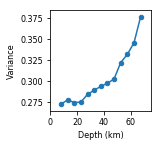

In [15]:
data=np.loadtxt('data/abic_variance_list_171001.txt')
abic, depth, variance, nmodel=(data[:,2], data[:,7], data[:,8], data[:,1])

w = 5.6; h = 5.6; wh=w/h
fig=plt.figure(figsize=(w, h))
#fig.patch.set_facecolor('k')
axwidth=0.25; axheight=0.25
ax=fig.add_axes([0.15,0.1,axwidth,axheight])
ax.set_xlabel('Depth (km)')
ax.set_ylabel('Variance')
ax.set_xlim([0, 75])
axp=ax.get_position()
ax.plot(depth, variance)
ax.scatter(depth, variance, s=20)

plt.savefig('fig/variance.jpg', bbox_inches="tight", pad_inches=0.1, transparent=False)
plt.show()